# Complex source reconstruction using _starlets_
This notebooks aims to be a first tentative to express light on pixelated grid, and building the mapping between source and image planes, for an implementation in _lenstronomy_.

In [1]:
__author__ = 'aymgal'
import os
import sys
import copy
import time
import pickle as pkl
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as pf
import pysap

import lenstronomy.Util.simulation_util as sim_util
import lenstronomy.Util.image_util as image_util
import lenstronomy.Util.util as lenstro_util
from lenstronomy.ImSim.image_model import ImageModel
from lenstronomy.Data.imaging_data import ImageData
from lenstronomy.Data.psf import PSF
from lenstronomy.LensModel.lens_model import LensModel
from lenstronomy.LightModel.light_model import LightModel
from lenstronomy.Util import kernel_util

from lenstronomy.ImSim.image_sparse_solve import ImageSparseFit
from slitronomy.Util.util import dirac_impulse
from slitronomy.Util.plot_util import nice_colorbar, log_cmap

%matplotlib inline


subgrid_res_source = 2
use_threshold_mask = False
perfect_seeing = False

# 'galsim_single', 'galsim_satellite', 'peaky_profile'
complex_source_type = 'galsim_single'

np.random.seed(18)

In [2]:
lin_scale = lambda x: x
log_scale = lambda x: np.log10(x)
sqrt_scale = lambda x: np.sqrt(x)

## Generate a mock lens

In [3]:
# data specifics
num_pix = 99  # cutout pixel size
delta_pix = 0.08  # pixel size in arcsec (area per pixel = deltaPix**2)

background_rms = 0.05  # background noise per pixel
#exp_time = 400  # exposure time (arbitrary units, flux per pixel is in units #photons/exp_time unit)

psf_fwhm = 0.2  # full width half max of PSF, in delta_pix units
psf_num_pix = 41

In [4]:
# data specification (coordinates, etc.)
_, _, ra_at_xy_0, dec_at_xy_0, _, _, Mpix2coord, _ \
    = lenstro_util.make_grid_with_coordtransform(numPix=num_pix, deltapix=delta_pix, subgrid_res=1, 
                                                 inverse=False, left_lower=False)

kwargs_data = {
    'background_rms': background_rms,
    #'exposure_time': exp_time,  # individual exposure time/weight per pixel
    'ra_at_xy_0': ra_at_xy_0, 'dec_at_xy_0': dec_at_xy_0, 
    'transform_pix2angle': Mpix2coord,
    'image_data': np.zeros((num_pix, num_pix))
}
data_class = ImageData(**kwargs_data)

(41, 41) (82, 82)


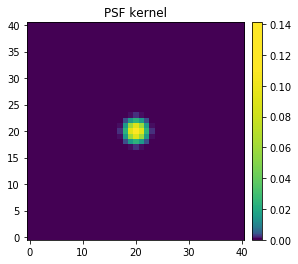

In [5]:
# PSF specification
if perfect_seeing:
    kwargs_psf = {'psf_type': 'NONE'}
else:
    psf_kernel = kernel_util.kernel_gaussian(psf_num_pix, delta_pix, psf_fwhm)
    psf_kernel_hd = kernel_util.kernel_gaussian(int(psf_num_pix*subgrid_res_source), 
                                                  delta_pix/subgrid_res_source, 
                                                  psf_fwhm)
    print(psf_kernel.shape, psf_kernel_hd.shape)
    kwargs_psf = {'psf_type': 'PIXEL', 'kernel_point_source': psf_kernel}
    #kwargs_psf = {'psf_type': 'GAUSSIAN', 'fwhm': psf_fwhm, 'pixel_size': delta_pix, 'truncation': 11}
psf_class = PSF(**kwargs_psf)

plt.title("PSF kernel")
im = plt.imshow(psf_class.kernel_point_source, origin='lower', cmap=log_cmap('viridis', 0.01, 0.8))
nice_colorbar(im)
plt.show()

In [6]:
lens_model_list = ['SPEMD']
kwargs_spemd = {'theta_E': 1.8, 'gamma': 2, 'center_x': 0, 'center_y': 0, 'e1': 0.1, 'e2': -0.2}
kwargs_lens = [kwargs_spemd]#, kwargs_shear]
lens_model_class = LensModel(lens_model_list=lens_model_list)

# list of source light profiles
if complex_source_type in ['galsim_single', 'galsim_satellite']:
    # get an pre-processed source galaxy from galsim
    galsim_index = 31
    snr = 500
    galsim_data_path = ('data/ring_sims/sims_SNR{}/simring_galsim{}_all.pkl'.format(snr, galsim_index))
    [data, truth, lens_model] = pkl.load(open(galsim_data_path, 'rb'))
    galsim_num_pix = data['num_pix']
    galsim_delta_pix = data['delta_pix']
    galsim_delta_pix /= 3  # because we are using high res x 3 galsim below
    galsim_source_highres = truth['source_galsim_3']
    source_model_list = ['INTERPOL']
    kwargs_interpol_source = {'image': galsim_source_highres, 'amp': 3000, 'center_x': +0.3, 'center_y': -0.1, 'phi_G': 0, 
                              'scale': galsim_delta_pix}
    kwargs_source = [kwargs_interpol_source]
    
    if complex_source_type == 'galsim_satellite':
        # get another pre-processed source galaxy from galsim
        galsim_index = 1
        snr = 500
        galsim_data_path = ('data/ring_sims/sims_SNR{}/simring_galsim{}_all.pkl'.format(snr, galsim_index))
        [data, truth, lens_model] = pkl.load(open(galsim_data_path, 'rb'))
        galsim_num_pix = data['num_pix']
        galsim_delta_pix = data['delta_pix']
        galsim_delta_pix /= 3  # because we are using high res x 3 galsim below
        galsim_source_highres = truth['source_galsim_3']
        source_model_list.append('INTERPOL')
        kwargs_interpol_source = {'image': galsim_source_highres, 'amp': 3000, 'center_x': -1, 'center_y': -0.4, 'phi_G': 0, 
                                  'scale': galsim_delta_pix}
        kwargs_source.append(kwargs_interpol_source)

elif complex_source_type == 'peaky_profile':
    source_model_list = ['SERSIC', 'SERSIC']
    kwargs_sersic_smooth = {'amp': 100, 'R_sersic': 0.2, 'n_sersic': 1, 'center_x': 0.3, 'center_y': -0.1}
    kwargs_sersic_peaky = {'amp': 100, 'R_sersic': 0.04, 'n_sersic': 4, 'center_x': 0.3, 'center_y': -0.1}
    kwargs_source = [kwargs_sersic_smooth, kwargs_sersic_peaky]
    
source_model_class = LightModel(light_model_list=source_model_list)

# list of lens light profiles
lens_light_model_list = []
kwargs_lens_light = [{}]
lens_light_model_class = LightModel(light_model_list=lens_light_model_list)

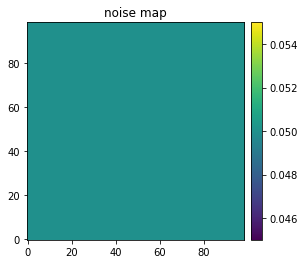

In [7]:
kwargs_numerics = {'supersampling_factor': 3, 'supersampling_convolution': False}

# get the simalated lens image (i.e. image plane)
imageModel = ImageModel(data_class, psf_class, lens_model_class, source_model_class, 
                        lens_light_model_class, point_source_class=None, 
                        kwargs_numerics=kwargs_numerics)

image_sim_no_noise = imageModel.image(kwargs_lens, kwargs_source, kwargs_lens_light, kwargs_ps=None)

bkg = image_util.add_background(image_sim_no_noise, sigma_bkd=background_rms)
#poisson = image_util.add_poisson(image_sim_no_noise, exp_time=exp_time)
noise = bkg # + poisson
image_sim = image_sim_no_noise + noise
image_sim_1d = lenstro_util.image2array(image_sim)

kwargs_data['image_data'] = image_sim
if kwargs_data.get('exposure_time', None) is None:
    use_regridding_error = False
    if use_regridding_error:
        data_x_grid, data_y_grid = data_class.coordinate_grid(num_pix, num_pix)
        mag_map = lenstro_util.array2image(lens_model_class.magnification(lenstro_util.image2array(data_x_grid), lenstro_util.image2array(data_y_grid), kwargs_lens))
        from noise import regridding_error_map_squared
        regrid_error2 = regridding_error_map_squared(image_sim, mag_map, delta_pix, delta_pix/subgrid_res_source)
        kwargs_data['noise_map'] = np.sqrt(regrid_error2 + background_rms**2)
    else:
        kwargs_data['noise_map'] = background_rms * np.ones_like(image_sim)
data_class = ImageData(**kwargs_data)

plt.title("noise map")
im = plt.imshow(np.sqrt(data_class.C_D), origin='lower')
nice_colorbar(im)
plt.show()

In [8]:
# get the light distribution in source plane
source_sim = imageModel.source_surface_brightness(kwargs_source, unconvolved=True, de_lensed=True)
source_sim_1d = lenstro_util.image2array(source_sim)

In [9]:
# get an automatic mask that includes the lensed source light
threshold_noise = 5
image_mask_1d = np.zeros_like(image_sim_1d)
mask_indices = np.where(image_sim_1d > threshold_noise * background_rms)
image_mask_1d[mask_indices] = 1
image_mask = lenstro_util.array2image(image_mask_1d)

## Visualize the lens & true source

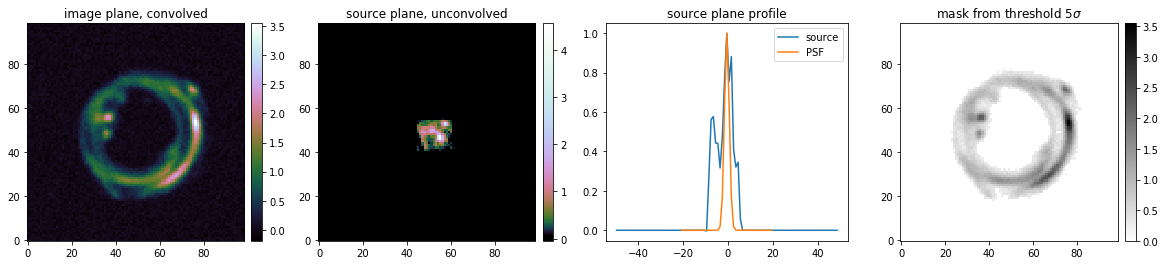

In [10]:
fig = plt.figure(figsize=(20, 4))

ax = plt.subplot2grid((1, 4), (0, 0), fig=fig)
ax.set_title("image plane, convolved")
im = ax.imshow(lin_scale(image_sim), origin='lower', cmap='cubehelix')
nice_colorbar(im)

ax = plt.subplot2grid((1, 4), (0, 1))
ax.set_title("source plane, unconvolved")
im = ax.imshow(lin_scale(source_sim), origin='lower', cmap=log_cmap('cubehelix', 0.03, 1))
nice_colorbar(im)

ax = plt.subplot2grid((1, 4), (0, 2))
ax.set_title("source plane profile")
ax.plot(np.arange(-num_pix/2, num_pix/2), source_sim[:, int(num_pix/2)]/source_sim[:, int(num_pix/2)].max(), label='source')
ax.plot(np.arange(-psf_num_pix/2, psf_num_pix/2), psf_kernel[:, int(psf_num_pix/2)]/psf_kernel[:, int(psf_num_pix/2)].max(), label='PSF')
ax.legend()

ax = plt.subplot2grid((1, 4), (0, 3))
ax.set_title("mask from threshold {}$\sigma$".format(threshold_noise))
im = ax.imshow(image_mask*image_sim, origin='lower', cmap='gray_r')
nice_colorbar(im)

plt.show()

## Sparse optimizazion to reconstruct the source light

In [11]:
source_model_list_sparsefit = ['STARLETS']
kwargs_starlets_source = {'n_scales': 6, 'n_pixels': np.size(image_sim)*subgrid_res_source**2}
kwargs_source_sparsefit = [kwargs_starlets_source]
source_model_class_sparsefit = LightModel(light_model_list=source_model_list_sparsefit)

kwargs_special_sparsefit = {
    'delta_x_source_grid': 0,
    'delta_y_source_grid': 0,
}

if use_threshold_mask:
    likelihood_mask = image_mask.astype(bool)
else:
    likelihood_mask = None

kwargs_sparse_solver = {
    'source_interpolation': 'bilinear',
    'subgrid_res_source': subgrid_res_source,
    'minimal_source_plane': True,
    'min_num_pix_source': 30,
    'max_threshold': 3,
    'num_iter_source': 20,
    'num_iter_weights': 3,
    'verbose': False,
    'show_steps': False,
    'thread_count': 1,  # number of processors
}

imageSparseFit = ImageSparseFit(data_class, psf_class=psf_class, 
                                lens_model_class=lens_model_class,
                                source_model_class=source_model_class_sparsefit,
                                likelihood_mask=likelihood_mask,
                                kwargs_sparse_solver=kwargs_sparse_solver)
print(type(imageSparseFit.sparseSolver))

<class 'slitronomy.Optimization.solver_source.SparseSolverSource'>


In [12]:
kwargs_lens_mod = copy.deepcopy(kwargs_lens)
#kwargs_lens_mod[0]['gamma'] = kwargs_lens[0]['gamma'] * 1.1

start_time = time.time()
model, model_error, param = imageSparseFit.image_sparse_solve(kwargs_lens_mod, 
                                                       kwargs_source=kwargs_source_sparsefit,
                                                       kwargs_lens_light=None,
                                                       kwargs_ps=None,
                                                       kwargs_special=kwargs_special_sparsefit)
end_time = time.time()
print("Runtime : {:.3f} s".format(end_time-start_time))

INFO : source grid has been reduced from 198 to 144 side pixels
Runtime : 0.939 s


## Plot results in image plane

Negative source pixels ? False (min = 0.00e+00)
Negative image pixels ? False (min = 3.13e-10)


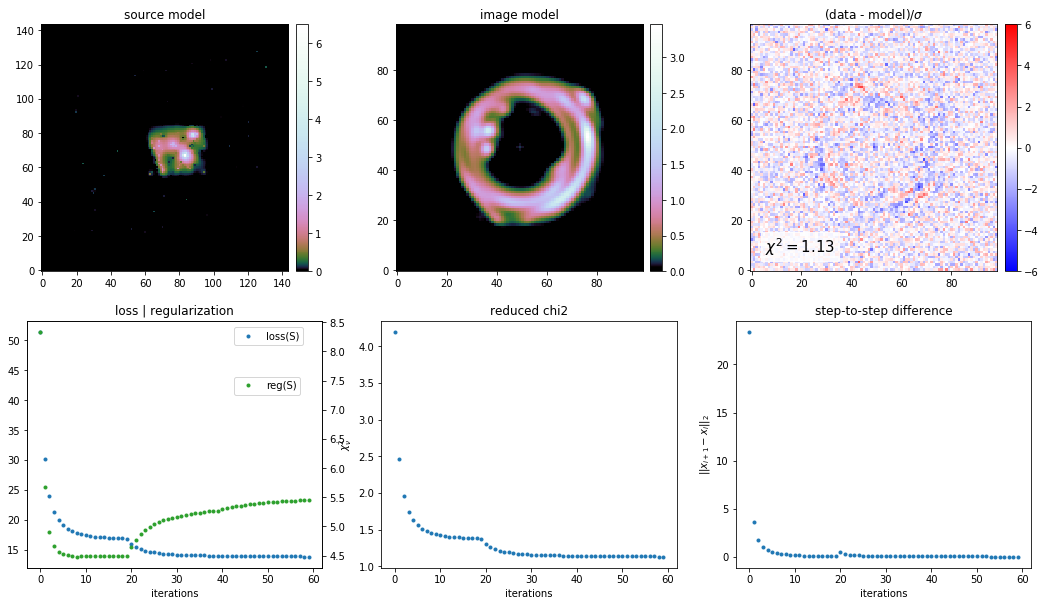

In [13]:
sparseSolver = imageSparseFit.sparseSolver
#lensingOperator = imageSparseFit.lensingOperator

fig = sparseSolver.plot_results(res_vmin=-6, res_vmax=6,
                                cmap_1=log_cmap('cubehelix', 1e-2, 1),
                                cmap_2=log_cmap('cubehelix', 2e-2, 1))

## Plot residuals in source plane

In [14]:
print("Updated kwargs :", kwargs_source_sparsefit)
print(kwargs_source_sparsefit[0]['amp'].shape)

Updated kwargs : [{'n_scales': 6, 'n_pixels': 39204, 'scale': 0.039999999999999994, 'center_x': 0, 'center_y': 0, 'amp': array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
       2.84471275e-06, 2.51394454e-06, 2.21055006e-06])}]
(235224,)


In [15]:
# get source reconstructions
source_estimate = imageSparseFit.source_surface_brightness(kwargs_source_sparsefit, kwargs_lens=None, 
                                                           unconvolved=True, de_lensed=True)

ra_grid_hd, dec_grid_hd = lenstro_util.make_grid(numPix=num_pix, deltapix=delta_pix,
                                                 subgrid_res=subgrid_res_source)
#ra_grid_hd, dec_grid_hd = sparseSolver.lensingOperator.sourcePlane.grid()
source_estimate_hd = source_model_class_sparsefit.surface_brightness(ra_grid_hd, dec_grid_hd, kwargs_source_sparsefit)
source_estimate_hd = lenstro_util.array2image(source_estimate_hd)

# get the true light distribution in source plane on high res grid
source_sim_hd = source_model_class.surface_brightness(ra_grid_hd, dec_grid_hd, kwargs_source)
source_sim_hd = lenstro_util.array2image(source_sim_hd)
source_sim_hd *= (delta_pix/subgrid_res_source)**2  # unit conversion
source_sim_hd *= subgrid_res_source**2  # pixeal area ratio

model_unconvolved = imageSparseFit.source_surface_brightness(kwargs_source_sparsefit, kwargs_lens=kwargs_lens,
                                                             unconvolved=True, de_lensed=False,
                                                             update_lens_mapping=False)

SDR = 8.925051888295968
SDR (restricted) = 9.053840677782556
SDR (HD, restricted) = 6.692770086643601
QOR = 1.0544066290778562
4.560075473785379 4.269650463014817 6.631304740905762 6.496090397238729


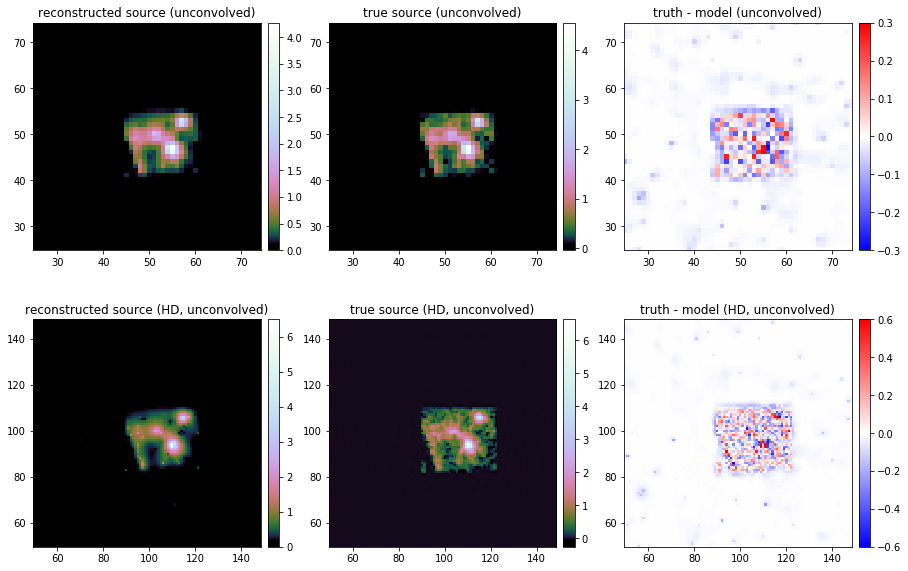

In [16]:
from metrics import SDR, QOR
print("SDR =", SDR(source_sim, source_estimate))
print("SDR (restricted) =", SDR(source_sim[33:63, 38:68], source_estimate[33:63, 38:68]))
print("SDR (HD, restricted) =", SDR(source_sim_hd[66:126, 76:136], source_estimate_hd[66:126, 76:136]))
#plt.imshow(source_sim_hd[66:126, 76:136], origin='lower')

print("QOR =", QOR(image_sim, sparseSolver.image_model(), np.sqrt(data_class.C_D)))

print(source_sim.max(), source_estimate.max(), source_sim_hd.max(), source_estimate_hd.max())
cut_level = 0.3
cut_level_hd = 0.6

residuals_source = source_sim - source_estimate
residuals_source_hd = source_sim_hd - source_estimate_hd

fig, axes = plt.subplots(2, 3, figsize=(15, 10))

ax = axes[0, 0]
ax.set_title("reconstructed source (unconvolved)")
im = ax.imshow(source_estimate, origin='lower', cmap=log_cmap('cubehelix', 0.03, 1))
ax.set_xlim(len(source_sim)/4, 3*len(source_sim)/4)
ax.set_ylim(len(source_sim)/4, 3*len(source_sim)/4)
nice_colorbar(im)
ax = axes[0, 1]
ax.set_title("true source (unconvolved)")
im = ax.imshow(source_sim, origin='lower', cmap=log_cmap('cubehelix', 0.03, 1))
ax.set_xlim(len(source_sim)/4, 3*len(source_sim)/4)
ax.set_ylim(len(source_sim)/4, 3*len(source_sim)/4)
nice_colorbar(im)
ax = axes[0, 2]
ax.set_title("truth - model (unconvolved)")
ax.set_xlim(len(source_sim)/4, 3*len(source_sim)/4)
ax.set_ylim(len(source_sim)/4, 3*len(source_sim)/4)
im = ax.imshow(residuals_source, origin='lower', cmap='bwr', vmin=-cut_level, vmax=cut_level)
nice_colorbar(im)

ax = axes[1, 0]
ax.set_title("reconstructed source (HD, unconvolved)")
im = ax.imshow(source_estimate_hd, origin='lower', cmap=log_cmap('cubehelix', 0.03, 1))
ax.set_xlim(len(source_estimate_hd)/4, 3*len(source_estimate_hd)/4)
ax.set_ylim(len(source_estimate_hd)/4, 3*len(source_estimate_hd)/4)
nice_colorbar(im)
ax = axes[1, 1]
ax.set_title("true source (HD, unconvolved)")
im = ax.imshow(source_sim_hd, origin='lower', cmap=log_cmap('cubehelix', 0.03, 1))
ax.set_xlim(len(source_sim_hd)/4, 3*len(source_sim_hd)/4)
ax.set_ylim(len(source_sim_hd)/4, 3*len(source_sim_hd)/4)
nice_colorbar(im)
ax = axes[1, 2]
ax.set_title("truth - model (HD, unconvolved)")
ax.set_xlim(len(source_sim_hd)/4, 3*len(source_sim_hd)/4)
ax.set_ylim(len(source_sim_hd)/4, 3*len(source_sim_hd)/4)
im = ax.imshow(residuals_source_hd, origin='lower', cmap='bwr', vmin=-cut_level_hd, vmax=cut_level_hd)
nice_colorbar(im)

plt.show()